In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import sys
import os
sys.path.append(os.path.abspath("../"))

from time import time
from mpl_toolkits.mplot3d import Axes3D
from learn import CompassModel, angdist

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor

names = [
    "seville-cr-16-20170121",
    "seville-cr-16-20170221",
    "seville-cr-16-20170321",
    "seville-cr-16-20170421",
    "seville-cr-16-20170521",
    "seville-cr-16-20170621",
    "seville-cr-16-20171008"
]

def transform_angle(z):
    z_dop, z_aop = z[..., 0::2], z[..., 1::2]
    z_sin = np.sin(z_aop)
    z_cos = np.cos(z_aop)
    z = np.zeros((z_dop.shape[0], 3 * z_dop.shape[1]))
    z[..., 0::3] = z_dop
    z[..., 1::3] = z_sin
    z[..., 2::3] = z_cos
    return z

scaler = StandardScaler()
# Load training data
x, y = CompassModel.load_dataset(names[:-1], pol=True, x_shape=(-1, 1, 1568, 2), time="full", y_shape=(-1, 1))
x = x.reshape((x.shape[0], -1))
i = np.all(~np.isnan(x), axis=1)
x, y = transform_angle(x[i]), y[i].squeeze()
scaler.fit(x)
x = scaler.transform(x)
print "Train:", x.shape, y.shape

# Load testing data
x_test, y_test = CompassModel.load_dataset(names[-1:], pol=True, x_shape=(-1, 1, 1568, 2), time="full", y_shape=(-1, 1))
x_test = x_test.reshape((x_test.shape[0], -1))
i = np.all(~np.isnan(x_test), axis=1)
x_test, y_test = scaler.transform(transform_angle(x_test[i])), y_test[i].squeeze()
print "Test:", x_test.shape, y_test.shape

Using TensorFlow backend.


Loading 'seville-cr-16-20170121.npz' ... (7560, 1568, 5) (7560,)
Loading 'seville-cr-16-20170221.npz' ... (8280, 1568, 5) (8280,)
Loading 'seville-cr-16-20170321.npz' ... (9000, 1568, 5) (9000,)
Loading 'seville-cr-16-20170421.npz' ... (9720, 1568, 5) (9720,)
Loading 'seville-cr-16-20170521.npz' ... (10440, 1568, 5) (10440,)
Loading 'seville-cr-16-20170621.npz' ... (10800, 1568, 5) (10800,)
Train: (53640, 4704) (53640,)
Loading 'seville-cr-16-20171008.npz' ... (8640, 1568, 5) (8640,)
Test: (7920, 4704) (7920,)


In [2]:
# PCA
pca = PCA()  # n_components=4)
print "Reducing dimensions..."
t0 = time()
pca.fit(x)
x_pca = pca.transform(x)
x_test_pca = pca.transform(x_test)
t1 = time()
eigenvalues = np.array(pca.explained_variance_)
print "New train:", x_pca.shape, "in %.2f sec" % (t1 - t0)

Reducing dimensions...
New train: (53640, 4704) in 431.19 sec


Number of dimensions that capture 98% of the variance: 189


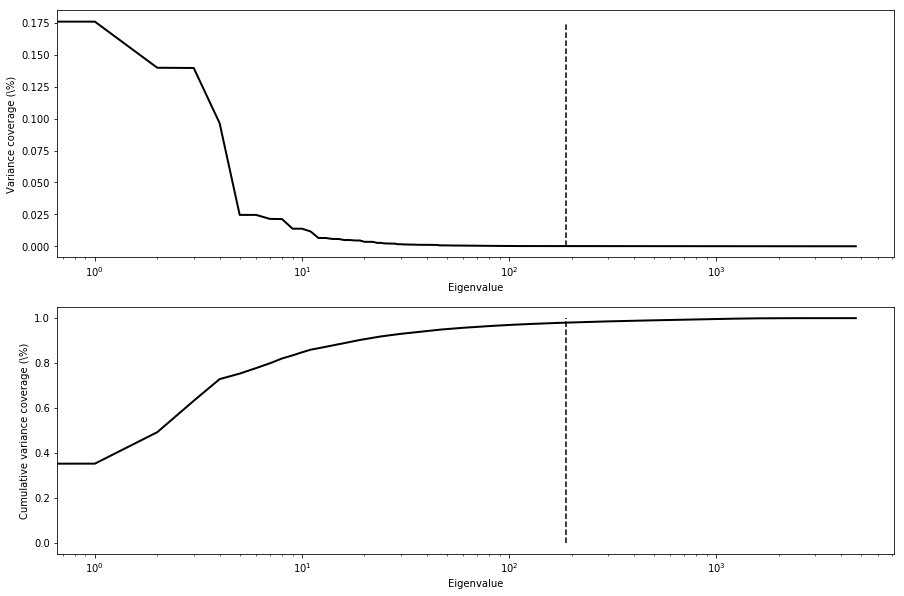

In [3]:
eigen_cum = [eigenvalues[0] / eigenvalues.sum()]
for e in eigenvalues[1:] / eigenvalues.sum():
    eigen_cum.append(eigen_cum[-1] + e)
eigen_cum = np.array(eigen_cum)
i, = np.where(eigen_cum >= .98)
print "Number of dimensions that capture 98% of the variance:", i[0] + 1

plt.figure(1, figsize=(15, 10))

plt.subplot(211)
plt.plot(eigenvalues / eigenvalues.sum(), 'k-', lw=2)
plt.plot([i[0], i[0]], [0., eigenvalues[0] / eigenvalues.sum()], 'k--')
plt.xscale('log')
plt.xlabel("Eigenvalue")
plt.ylabel("Variance coverage (\%)")

plt.subplot(212)
plt.plot(eigen_cum, 'k-', lw=2)
plt.plot([i[0], i[0]], [0., 1.], 'k--')
plt.xscale('log')
plt.xlabel("Eigenvalue")
plt.ylabel("Cumulative variance coverage (\%)")

plt.show()

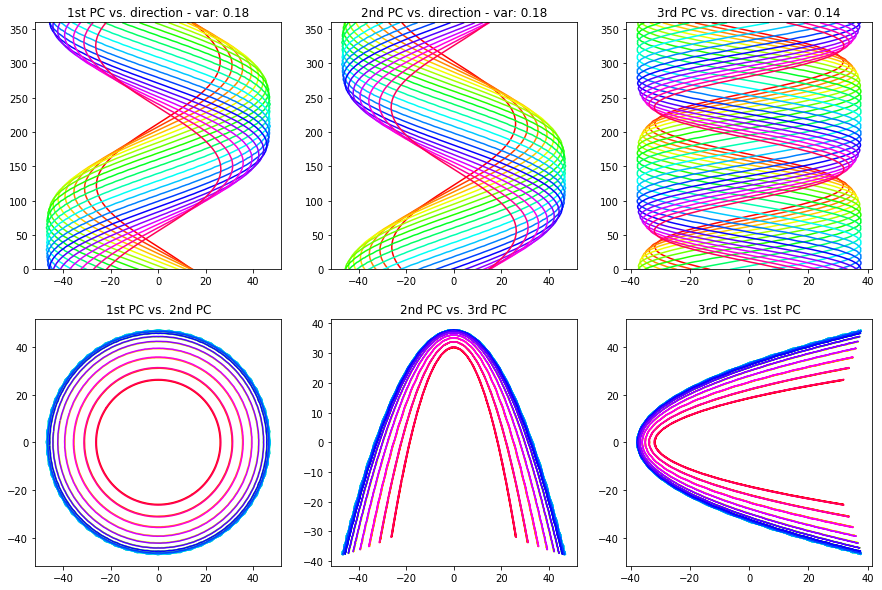

In [4]:
N = x_test_pca.shape[0] / 360
plt.figure(1, figsize=(15, 10))
plt.subplot(231)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 0], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("1st PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(232)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 1], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("2nd PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(233)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 2], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("3rd PC vs. direction - var: %.2f" % (eigenvalues[2] / eigenvalues.sum()))

plt.subplot(234)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1], color=cmx.hsv(i/float(N)))
plt.title("1st PC vs. 2nd PC")

plt.subplot(235)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2], color=cmx.hsv(i/float(N)))
plt.title("2nd PC vs. 3rd PC")

plt.subplot(236)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0], color=cmx.hsv(i/float(N)))
plt.title("3rd PC vs. 1st PC")

plt.show()

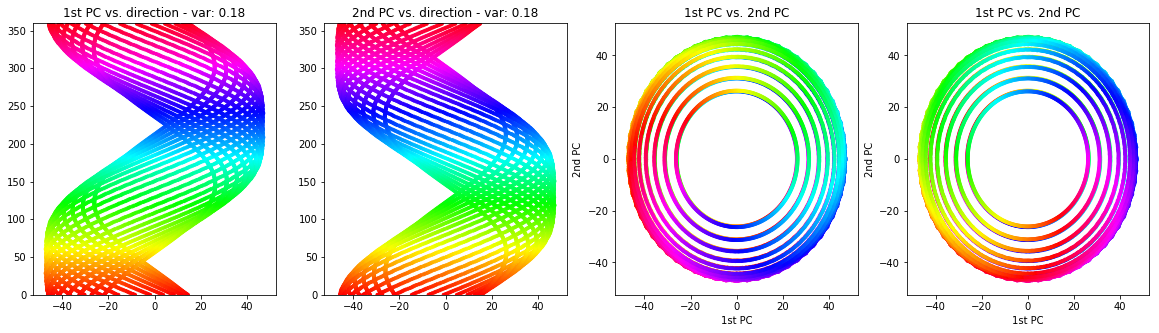

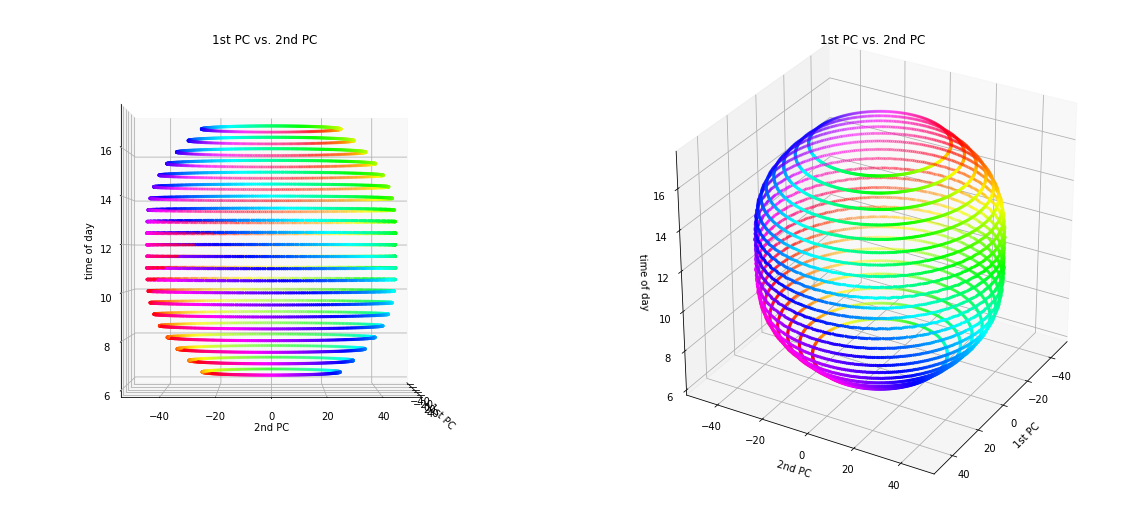

In [5]:
N = x_test_pca.shape[0] / 360
noon = N / 2.
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("1st PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(142)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("2nd PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(143)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(144)
for i in range(0, N)[::-1]:
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.figure(2, figsize=(20, 20))
ax = plt.subplot(221, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 0],
        x_test_pca[(i*360):((i+1)*360), 1],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_zlabel("time of day")
ax.view_init(0, 0)
plt.title("1st PC vs. 2nd PC")

ax = plt.subplot(222, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 0],
        x_test_pca[(i*360):((i+1)*360), 1],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_zlabel("time of day")
ax.view_init(30, 30)
plt.title("1st PC vs. 2nd PC")
plt.show()

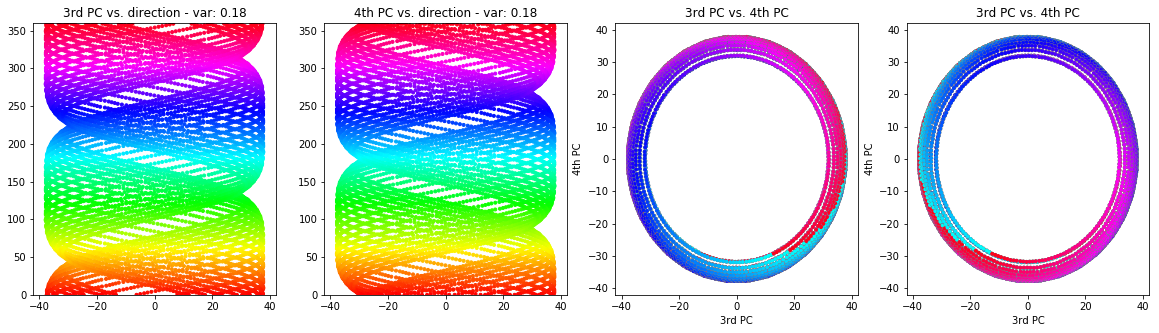

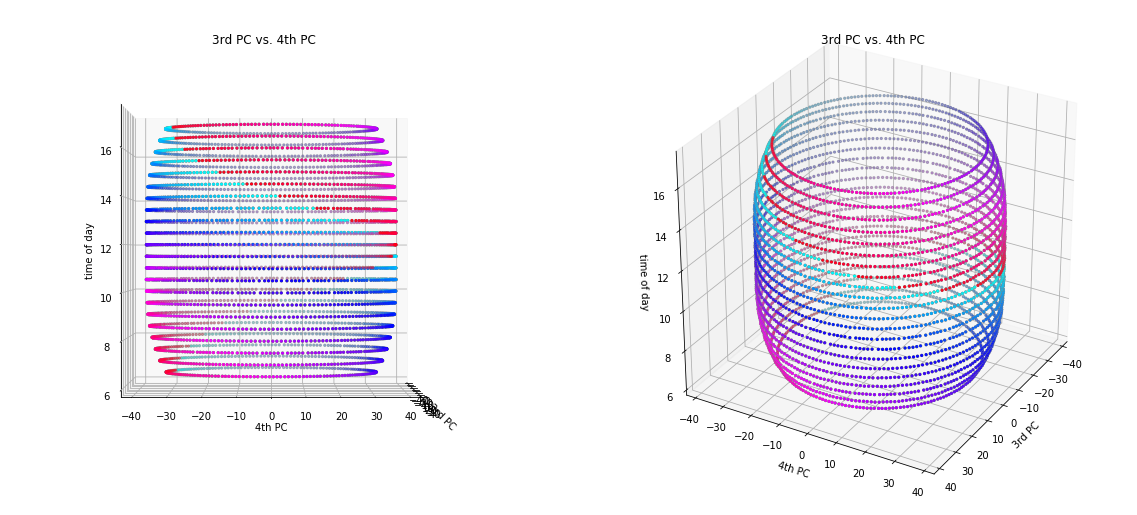

In [6]:
N = x_test_pca.shape[0] / 360
noon = N / 2.
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("3rd PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(142)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 3], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("4th PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(143)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 3],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("4th PC")
plt.title("3rd PC vs. 4th PC")

plt.subplot(144)
for i in range(0, N)[::-1]:
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 3],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("4th PC")
plt.title("3rd PC vs. 4th PC")

plt.figure(2, figsize=(20, 20))
ax = plt.subplot(221, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 2],
        x_test_pca[(i*360):((i+1)*360), 3],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("3rd PC")
ax.set_ylabel("4th PC")
ax.set_zlabel("time of day")
ax.view_init(0, 0)
plt.title("3rd PC vs. 4th PC")

ax = plt.subplot(222, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 2],
        x_test_pca[(i*360):((i+1)*360), 3],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("3rd PC")
ax.set_ylabel("4th PC")
ax.set_zlabel("time of day")
ax.view_init(30, 30)
plt.title("3rd PC vs. 4th PC")
plt.show()

# Use only afternoon times to train and test the model

In [3]:
names = [
    "seville-cr-16-20170121",
    "seville-cr-16-20170221",
    "seville-cr-16-20170321",
    "seville-cr-16-20170421",
    "seville-cr-16-20170521",
    "seville-cr-16-20170621",
    "seville-cr-16-20171008"
]

del x, y, x_test, y_test
# Load training data
x, y = CompassModel.load_dataset(names[:-1], pol=True, x_shape=(-1, 1, 1568, 2), time="afternoon", y_shape=(-1, 1))
x = x.reshape((x.shape[0], -1))
i = np.all(~np.isnan(x), axis=1)
x, y = scaler.transform(transform_angle(x[i])), y[i].squeeze()
print "Train:", x.shape, y.shape

# Load testing data
x_test, y_test = CompassModel.load_dataset(names[-1:], pol=True, x_shape=(-1, 1, 1568, 2), time="afternoon", y_shape=(-1, 1))
x_test = x_test.reshape((x_test.shape[0], -1))
i = np.all(~np.isnan(x_test), axis=1)
x_test, y_test = scaler.transform(transform_angle(x_test[i])), y_test[i].squeeze()
print "Test:", x_test.shape, y_test.shape

Loading 'seville-cr-16-20170121.npz' ... (3780, 1568, 5) (3780,)
Loading 'seville-cr-16-20170221.npz' ... (4140, 1568, 5) (4140,)
Loading 'seville-cr-16-20170321.npz' ... (4500, 1568, 5) (4500,)
Loading 'seville-cr-16-20170421.npz' ... (4860, 1568, 5) (4860,)
Loading 'seville-cr-16-20170521.npz' ... (5220, 1568, 5) (5220,)
Loading 'seville-cr-16-20170621.npz' ... (5400, 1568, 5) (5400,)
Train: (27900, 4704) (27900,)
Loading 'seville-cr-16-20171008.npz' ... (4320, 1568, 5) (4320,)
Test: (3960, 4704) (3960,)


In [4]:
# PCA
print "Reducing dimensions..."
t0 = time()
x_pca = pca.transform(x)
x_test_pca = pca.transform(x_test)
t1 = time()
eigenvalues = np.array(pca.explained_variance_)
print "New train:", x_pca.shape, "in %.2f sec" % (t1 - t0)

Reducing dimensions...
New train: (27900, 4704) in 25.43 sec


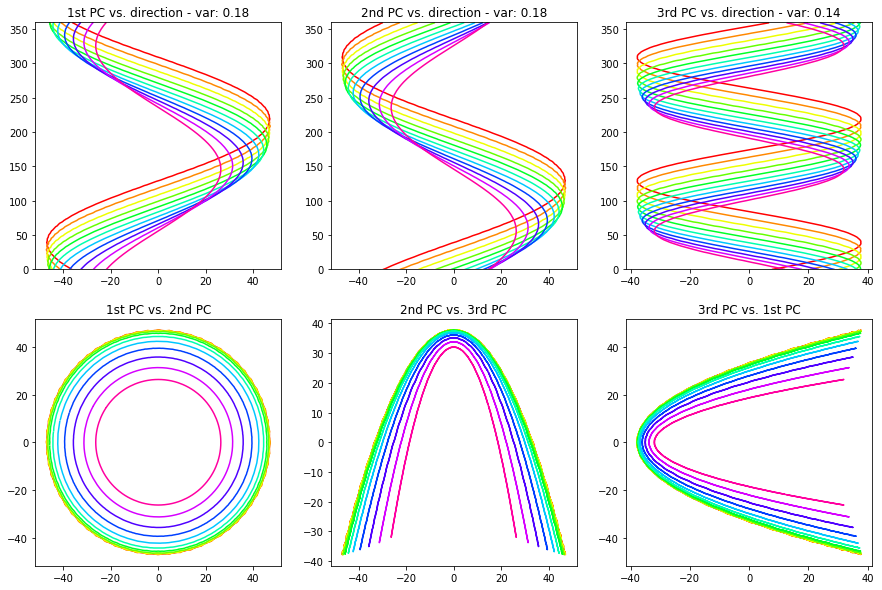

In [5]:
N = x_test_pca.shape[0] / 360
plt.figure(1, figsize=(15, 10))
plt.subplot(231)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 0], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("1st PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(232)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 1], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("2nd PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(233)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 2], np.rad2deg(y_test[(i*360):((i+1)*360)]), color=cmx.hsv(i/float(N)))
plt.ylim([0, 360])
plt.title("3rd PC vs. direction - var: %.2f" % (eigenvalues[2] / eigenvalues.sum()))

plt.subplot(234)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1], color=cmx.hsv(i/float(N)))
plt.title("1st PC vs. 2nd PC")

plt.subplot(235)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2], color=cmx.hsv(i/float(N)))
plt.title("2nd PC vs. 3rd PC")

plt.subplot(236)
for i in xrange(N):
    plt.plot(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0], color=cmx.hsv(i/float(N)))
plt.title("3rd PC vs. 1st PC")

plt.show()

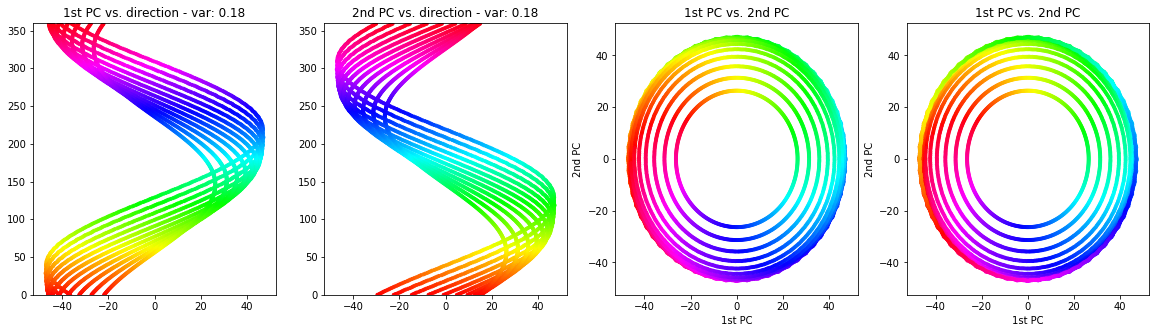

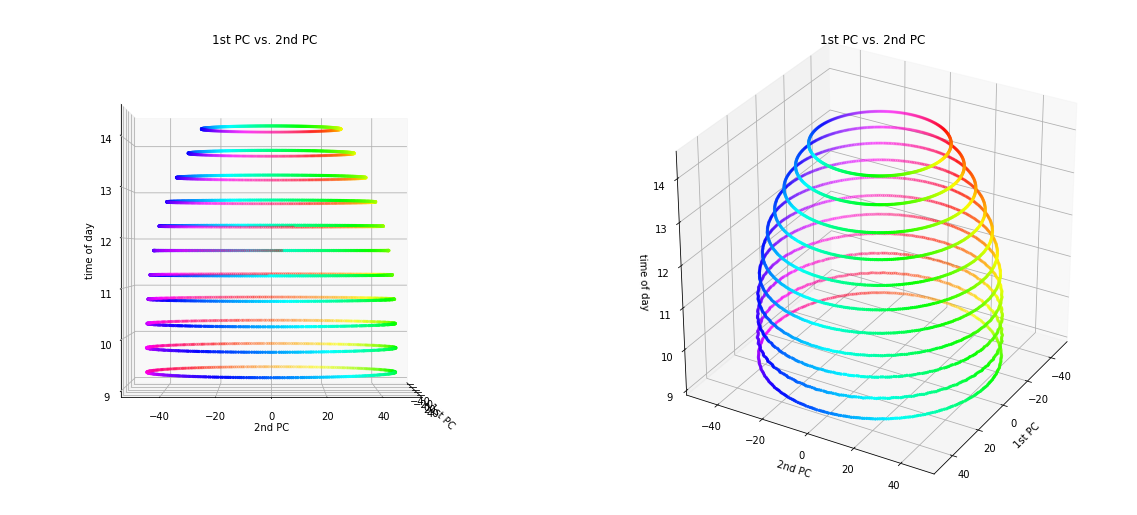

In [10]:
N = x_test_pca.shape[0] / 360
noon = N / 2.
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("1st PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(142)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("2nd PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(143)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(144)
for i in range(0, N)[::-1]:
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.figure(2, figsize=(20, 20))
ax = plt.subplot(221, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 0],
        x_test_pca[(i*360):((i+1)*360), 1],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_zlabel("time of day")
ax.view_init(0, 0)
plt.title("1st PC vs. 2nd PC")

ax = plt.subplot(222, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 0],
        x_test_pca[(i*360):((i+1)*360), 1],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_zlabel("time of day")
ax.view_init(30, 30)
plt.title("1st PC vs. 2nd PC")
plt.show()

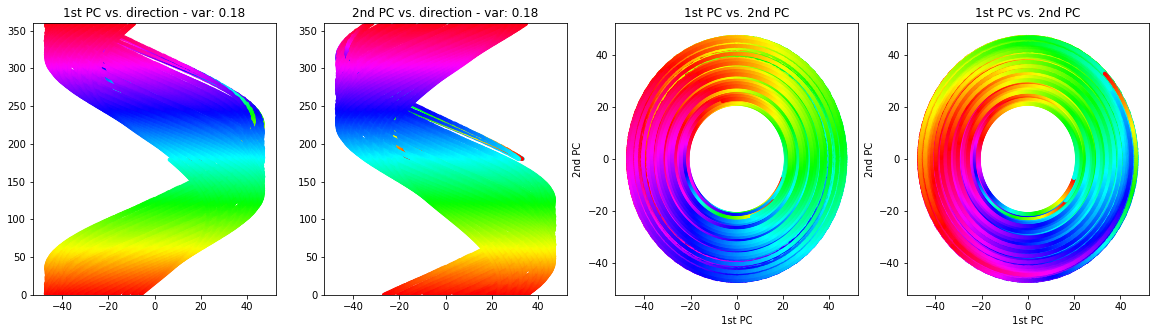

In [11]:
N = x_pca.shape[0] / 360
noon = N / 2.
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
for i in xrange(N):
    plt.scatter(x_pca[(i*360):((i+1)*360), 0], np.rad2deg(y[(i*360):((i+1)*360)]),
               marker='.', c=y[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("1st PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(142)
for i in xrange(N):
    plt.scatter(x_pca[(i*360):((i+1)*360), 1], np.rad2deg(y[(i*360):((i+1)*360)]),
               marker='.', c=y[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("2nd PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(143)
for i in xrange(N):
    plt.scatter(x_pca[(i*360):((i+1)*360), 0], x_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(144)
for i in range(0, N)[::-1]:
    plt.scatter(x_pca[(i*360):((i+1)*360), 0], x_pca[(i*360):((i+1)*360), 1],
                marker='.', c=y[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.show()

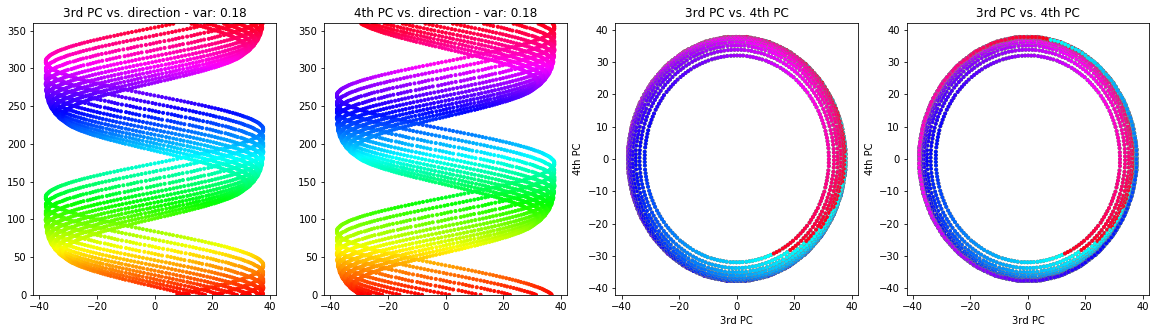

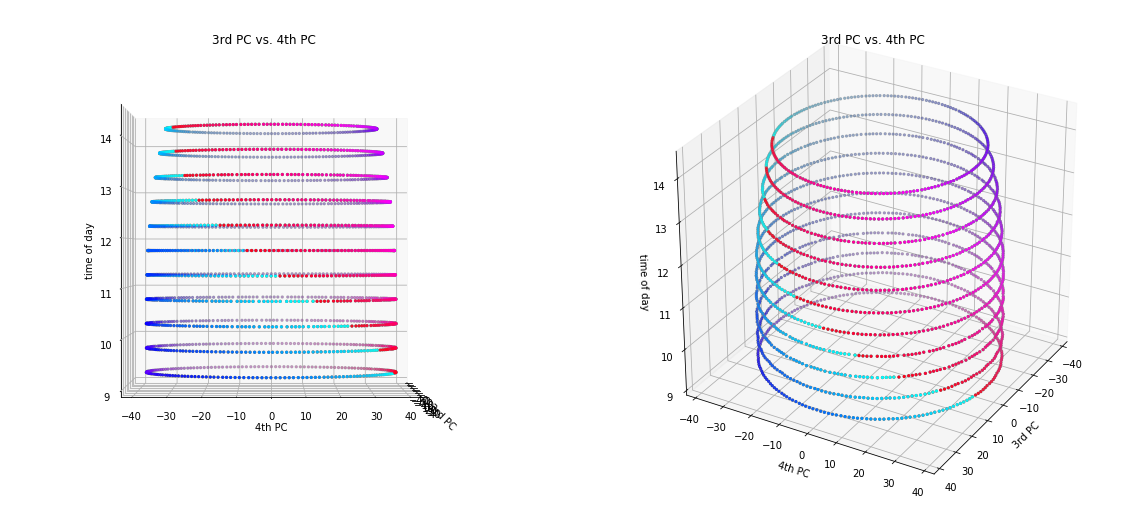

In [12]:
N = x_test_pca.shape[0] / 360
noon = N / 2.
plt.figure(1, figsize=(20, 5))
plt.subplot(141)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("3rd PC vs. direction - var: %.2f" % (eigenvalues[0] / eigenvalues.sum()))

plt.subplot(142)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 3], np.rad2deg(y_test[(i*360):((i+1)*360)]),
               marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.ylim([0, 360])
plt.title("4th PC vs. direction - var: %.2f" % (eigenvalues[1] / eigenvalues.sum()))

plt.subplot(143)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 3],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("4th PC")
plt.title("3rd PC vs. 4th PC")

plt.subplot(144)
for i in range(0, N)[::-1]:
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 3],
                marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("4th PC")
plt.title("3rd PC vs. 4th PC")

plt.figure(2, figsize=(20, 20))
ax = plt.subplot(221, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 2],
        x_test_pca[(i*360):((i+1)*360), 3],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("3rd PC")
ax.set_ylabel("4th PC")
ax.set_zlabel("time of day")
ax.view_init(0, 0)
plt.title("3rd PC vs. 4th PC")

ax = plt.subplot(222, projection='3d')
for i in xrange(N):
    ax.scatter3D(
        x_test_pca[(i*360):((i+1)*360), 2],
        x_test_pca[(i*360):((i+1)*360), 3],
        12 - (noon - i) * .5,
        marker='.', c=y_test[(i*360):((i+1)*360)], cmap='hsv')
ax.set_xlabel("3rd PC")
ax.set_ylabel("4th PC")
ax.set_zlabel("time of day")
ax.view_init(30, 30)
plt.title("3rd PC vs. 4th PC")
plt.show()

In [7]:
ln = LinearRegression(n_jobs=3)
lg = LogisticRegression(n_jobs=3, max_iter=500, multi_class='multinomial', solver='sag')
nn = MLPRegressor(hidden_layer_sizes=(360,), activation='logistic', alpha=1e-4, solver='adam', max_iter=500)

## Train using the first 4 dimensions

In [8]:
D = 4
ln.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_ln = np.deg2rad(ln.predict(x_pca[..., :D]))
acc_ln = 1 - angdist(y, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

lg.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_lg = np.deg2rad(lg.predict(x_pca[..., :D]))
acc_lg = 1 - angdist(y, p_lg).mean() / np.pi
print "Logistic Regression - Accuracy:", acc_lg

nn.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_nn = np.deg2rad(nn.predict(x_pca[..., :D]))
acc_nn = 1 - angdist(y, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.741251683084
Logistic Regression - Accuracy: 0.841828749834
Neural Network      - Accuracy: 0.765075272417


## Test

In [9]:
lg.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_lg = np.deg2rad(lg.predict(x_pca[..., :D]))
acc_lg = 1 - angdist(y, p_lg).mean() / np.pi
print "Logistic Regression - Accuracy:", acc_lg

p_ln = np.deg2rad(ln.predict(x_test_pca[..., :D]))
acc_ln = 1 - angdist(y_test, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

p_nn = np.deg2rad(nn.predict(x_test_pca[..., :D]))
acc_nn = 1 - angdist(y_test, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.764238449541
Logistic Regression - Accuracy: 0.840213241523
Neural Network      - Accuracy: 0.796556329752


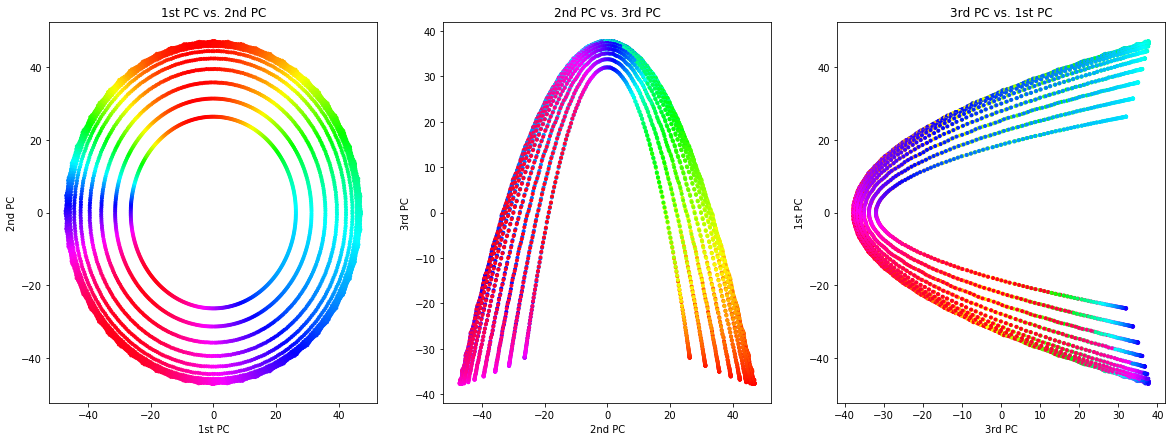

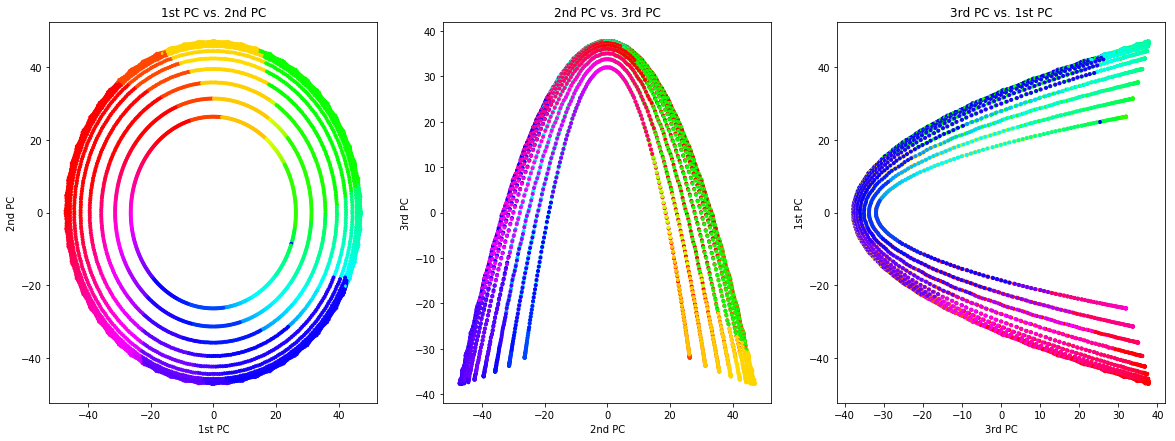

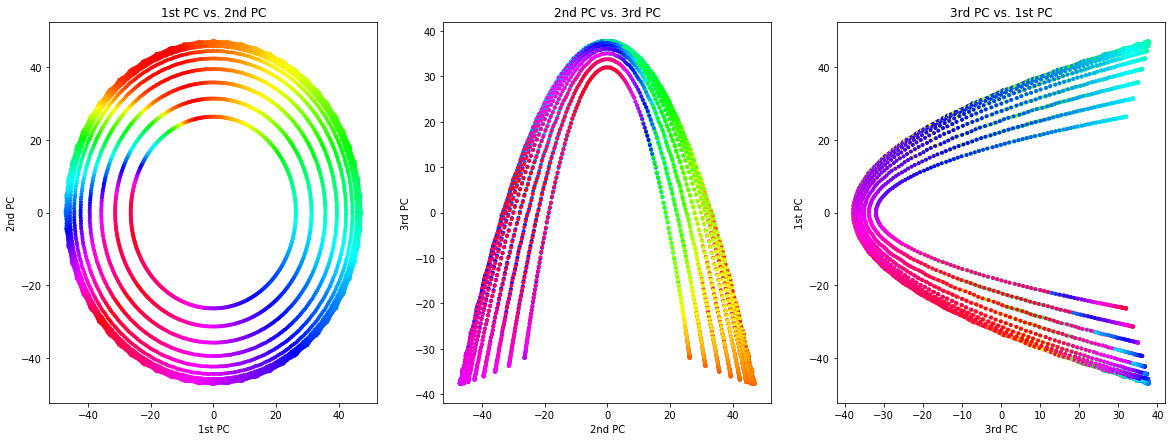

In [10]:
N = x_test_pca.shape[0] / 360
plt.figure(1, figsize=(20, 7))
plt.subplot(131)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(132)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("2nd PC")
plt.ylabel("3rd PC")
plt.title("2nd PC vs. 3rd PC")

plt.subplot(133)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("1st PC")
plt.title("3rd PC vs. 1st PC")

plt.figure(2, figsize=(20, 7))
plt.subplot(131)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=p_lg[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(132)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2],
                marker='.', c=p_lg[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("2nd PC")
plt.ylabel("3rd PC")
plt.title("2nd PC vs. 3rd PC")

plt.subplot(133)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0],
                marker='.', c=p_lg[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("1st PC")
plt.title("3rd PC vs. 1st PC")

plt.figure(3, figsize=(20, 7))
plt.subplot(131)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(132)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("2nd PC")
plt.ylabel("3rd PC")
plt.title("2nd PC vs. 3rd PC")

plt.subplot(133)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("1st PC")
plt.title("3rd PC vs. 1st PC")

plt.show()

## Train using 98% of the variance

In [11]:
D = 189

lg.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_lg = np.deg2rad(lg.predict(x_pca[..., :D]))
acc_lg = 1 - angdist(y, p_lg).mean() / np.pi
print "Logistic Regression - Accuracy:", acc_lg

ln.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_ln = np.deg2rad(ln.predict(x_pca[..., :D]))
acc_ln = 1 - angdist(y, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

nn.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_nn = np.deg2rad(nn.predict(x_pca[..., :D]))
acc_nn = 1 - angdist(y, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression - Accuracy: 0.847169251391
Linear Regression   - Accuracy: 0.789469492787


/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Neural Network      - Accuracy: 0.876166221624


### Test

In [12]:
p_lg = np.deg2rad(lg.predict(x_test_pca[..., :D]))
acc_lg = 1 - angdist(y_test, p_lg).mean() / np.pi
print "Logistic Regression - Accuracy:", acc_lg

p_ln = np.deg2rad(ln.predict(x_test_pca[..., :D]))
acc_ln = 1 - angdist(y_test, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

p_nn = np.deg2rad(nn.predict(x_test_pca[..., :D]))
acc_nn = 1 - angdist(y_test, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Logistic Regression - Accuracy: 0.752760936282
Linear Regression   - Accuracy: 0.792977294599
Neural Network      - Accuracy: 0.800016662619


## Train using 100% of the variance

In [21]:
D = 4704
ln.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_ln = np.deg2rad(ln.predict(x_pca[..., :D])) % (2 * np.pi)
acc_ln = 1 - angdist(y, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

nn.fit(x_pca[..., :D], np.int32(np.rad2deg(y)))
p_nn = np.deg2rad(nn.predict(x_pca[..., :D])) % (2 * np.pi)
acc_nn = 1 - angdist(y, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.847335916745
Neural Network      - Accuracy: 0.971618401057


### Test

In [22]:
p_ln = np.deg2rad(ln.predict(x_test_pca[..., :D])) % (2 * np.pi)
acc_ln = 1 - angdist(y_test, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

p_nn = np.deg2rad(nn.predict(x_test_pca[..., :D])) % (2 * np.pi)
acc_nn = 1 - angdist(y_test, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.798021079011
Neural Network      - Accuracy: 0.800604699777


## Train using RAW data

In [23]:
ln.fit(x, np.int32(np.rad2deg(y)))
p_ln = np.deg2rad(ln.predict(x)) % (2 * np.pi)
acc_ln = 1 - angdist(y, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

nn.fit(x, np.int32(np.rad2deg(y)))
p_nn = np.deg2rad(nn.predict(x)) % (2 * np.pi)
acc_nn = 1 - angdist(y, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.848849695657
Neural Network      - Accuracy: 0.790436062975


### Test

In [24]:
p_ln = np.deg2rad(ln.predict(x_test)) % (2 * np.pi)
acc_ln = 1 - angdist(y_test, p_ln).mean() / np.pi
print "Linear Regression   - Accuracy:", acc_ln

p_nn = np.deg2rad(nn.predict(x_test)) % (2 * np.pi)
acc_nn = 1 - angdist(y_test, p_nn).mean() / np.pi
print "Neural Network      - Accuracy:", acc_nn

Linear Regression   - Accuracy: 0.796708634421
Neural Network      - Accuracy: 0.79725900757


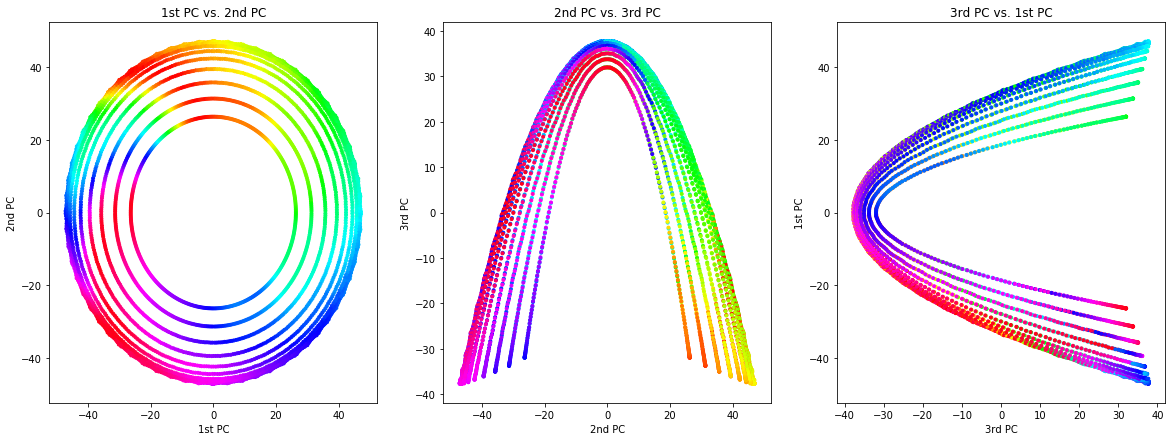

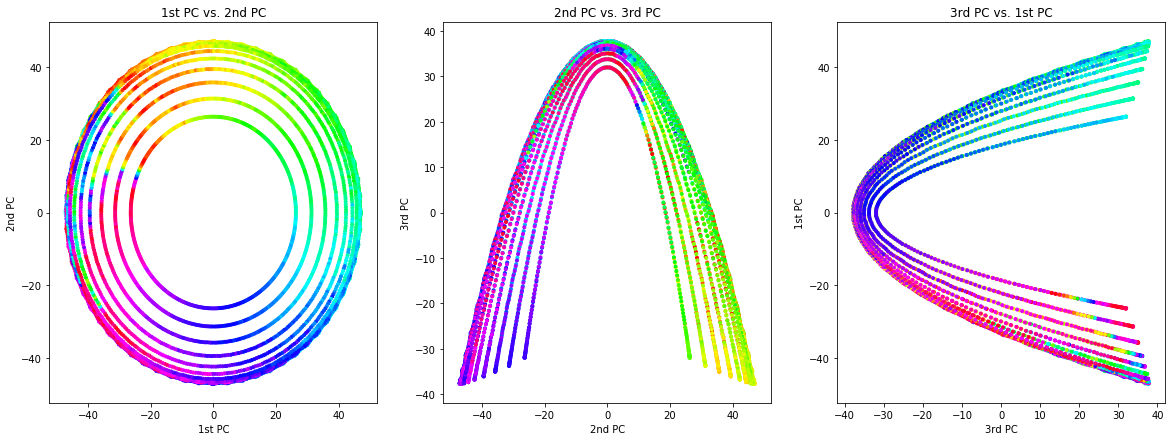

In [13]:
N = x_test_pca.shape[0] / 360
plt.figure(1, figsize=(20, 7))
plt.subplot(131)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(132)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("2nd PC")
plt.ylabel("3rd PC")
plt.title("2nd PC vs. 3rd PC")

plt.subplot(133)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0],
                marker='.', c=p_ln[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("1st PC")
plt.title("3rd PC vs. 1st PC")

plt.figure(2, figsize=(20, 7))
plt.subplot(131)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 0], x_test_pca[(i*360):((i+1)*360), 1],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("1st PC vs. 2nd PC")

plt.subplot(132)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 1], x_test_pca[(i*360):((i+1)*360), 2],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("2nd PC")
plt.ylabel("3rd PC")
plt.title("2nd PC vs. 3rd PC")

plt.subplot(133)
for i in xrange(N):
    plt.scatter(x_test_pca[(i*360):((i+1)*360), 2], x_test_pca[(i*360):((i+1)*360), 0],
                marker='.', c=p_nn[(i*360):((i+1)*360)], cmap='hsv')
plt.xlabel("3rd PC")
plt.ylabel("1st PC")
plt.title("3rd PC vs. 1st PC")

plt.show()